# Loop 15 Analysis: Understanding the Gap

## Key Observations:
1. Our score (70.63) is BETTER than public LB leader (71.19)
2. Target (68.919) is 2.27 points below public LB leader
3. After 16 experiments, only microscopic improvements found (0.00001)
4. All optimization approaches converge to the same local optimum

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

getcontext().prec = 25
scale_factor = Decimal("1e15")

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (Decimal('0.0') * scale_factor, tip_y * scale_factor),
            (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def calculate_score(trees):
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / 1e15 for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    score = max(max_x - min_x, max_y - min_y) ** 2 / len(trees)
    return score

def load_trees(n, df):
    group_data = df[df["id"].str.startswith(f"{n:03d}_")]
    trees = []
    for _, row in group_data.iterrows():
        x = str(row["x"]).lstrip('s')
        y = str(row["y"]).lstrip('s')
        deg = str(row["deg"]).lstrip('s')
        trees.append(ChristmasTree(x, y, deg))
    return trees

print("Functions loaded successfully")

Functions loaded successfully


In [2]:
# Load current best solution and analyze per-N scores
df = pd.read_csv('/home/submission/submission.csv')

per_n_scores = []
for n in range(1, 201):
    trees = load_trees(n, df)
    if len(trees) == n:
        score = calculate_score(trees)
        per_n_scores.append({'N': n, 'score': score, 'efficiency': n / score})

per_n_df = pd.DataFrame(per_n_scores)
print(f"Total score: {per_n_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap: {per_n_df['score'].sum() - 68.919154:.6f}")
print(f"\nPer-N score statistics:")
print(per_n_df.describe())

Total score: 70.630465
Target: 68.919154
Gap: 1.711311

Per-N score statistics:
                N       score  efficiency
count  200.000000  200.000000  200.000000
mean   100.500000    0.353152  292.915437
std     57.879185    0.028098  174.251070
min      1.000000    0.329945    1.512287
25%     50.750000    0.340034  139.280050
50%    100.500000    0.346934  290.372757
75%    150.250000    0.360823  444.091074
max    200.000000    0.661250  592.506257


In [3]:
# Calculate theoretical lower bound
# For a single tree at 45 degrees, the bounding box is sqrt(2) * max_dimension
# The tree has dimensions roughly 0.7 wide x 1.0 tall
# At 45 degrees, the bounding box is approximately sqrt(0.7^2 + 1.0^2) * sqrt(2) = 1.22 * 1.414 = 1.72

# Actually, let's calculate the exact single tree bounding box at 45 degrees
tree = ChristmasTree('0', '0', '45')
bounds = tree.polygon.bounds
width = (bounds[2] - bounds[0]) / 1e15
height = (bounds[3] - bounds[1]) / 1e15
side = max(width, height)
print(f"Single tree at 45 degrees:")
print(f"  Width: {width:.6f}")
print(f"  Height: {height:.6f}")
print(f"  Side: {side:.6f}")
print(f"  Score (N=1): {side**2:.6f}")

# Theoretical lower bound: if we could pack trees with 100% efficiency
# The tree area is approximately 0.5 * 0.7 * 1.0 = 0.35 (rough estimate)
# For N trees, minimum square side would be sqrt(N * tree_area)
tree_area = tree.polygon.area / 1e30  # Convert from scaled units
print(f"\nTree area: {tree_area:.6f}")

# Theoretical minimum score if 100% packing efficiency
theoretical_min = sum(tree_area * n / n for n in range(1, 201))  # This is just 200 * tree_area
print(f"Theoretical minimum (100% efficiency): {theoretical_min:.6f}")
print(f"\nNote: 100% efficiency is impossible due to tree shape")

Single tree at 45 degrees:
  Width: 0.813173
  Height: 0.813173
  Side: 0.813173
  Score (N=1): 0.661250

Tree area: 0.245625
Theoretical minimum (100% efficiency): 49.125000

Note: 100% efficiency is impossible due to tree shape


In [4]:
# Analyze which N values have the most room for improvement
# Compare current score with theoretical minimum for each N

per_n_df['theoretical_min'] = per_n_df['N'].apply(lambda n: tree_area)  # Minimum is tree_area per tree
per_n_df['gap_to_theoretical'] = per_n_df['score'] - per_n_df['theoretical_min']
per_n_df['packing_efficiency'] = per_n_df['theoretical_min'] / per_n_df['score']

print("N values with worst packing efficiency (most room for improvement):")
print(per_n_df.nsmallest(20, 'packing_efficiency')[['N', 'score', 'packing_efficiency']])

N values with worst packing efficiency (most room for improvement):
     N     score  packing_efficiency
0    1  0.661250            0.371456
1    2  0.450779            0.544890
2    3  0.434745            0.564986
4    5  0.416850            0.589241
3    4  0.416545            0.589672
6    7  0.399897            0.614221
5    6  0.399610            0.614661
8    9  0.387415            0.634010
7    8  0.385407            0.637313
14  15  0.376978            0.651563
9   10  0.376630            0.652165
20  21  0.376451            0.652476
19  20  0.376057            0.653159
21  22  0.375258            0.654549
10  11  0.374924            0.655133
15  16  0.374128            0.656527
25  26  0.373997            0.656757
11  12  0.372724            0.659000
12  13  0.372294            0.659761
24  25  0.372144            0.660026


In [5]:
# Calculate what improvement we need per N to reach target
target = 68.919154
current_total = per_n_df['score'].sum()
gap = current_total - target

print(f"Current total: {current_total:.6f}")
print(f"Target: {target:.6f}")
print(f"Gap: {gap:.6f}")
print(f"\nIf we improve each N by the same percentage:")
required_improvement_pct = gap / current_total * 100
print(f"Required improvement: {required_improvement_pct:.4f}%")

print(f"\nIf we improve each N by the same absolute amount:")
required_improvement_per_n = gap / 200
print(f"Required improvement per N: {required_improvement_per_n:.6f}")

print(f"\nTree removal found improvement of 0.00001345 for N=88")
print(f"Improvements needed at that rate: {gap / 0.00001345:.0f}")

Current total: 70.630465
Target: 68.919154
Gap: 1.711311

If we improve each N by the same percentage:
Required improvement: 2.4229%

If we improve each N by the same absolute amount:
Required improvement per N: 0.008557

Tree removal found improvement of 0.00001345 for N=88
Improvements needed at that rate: 127235


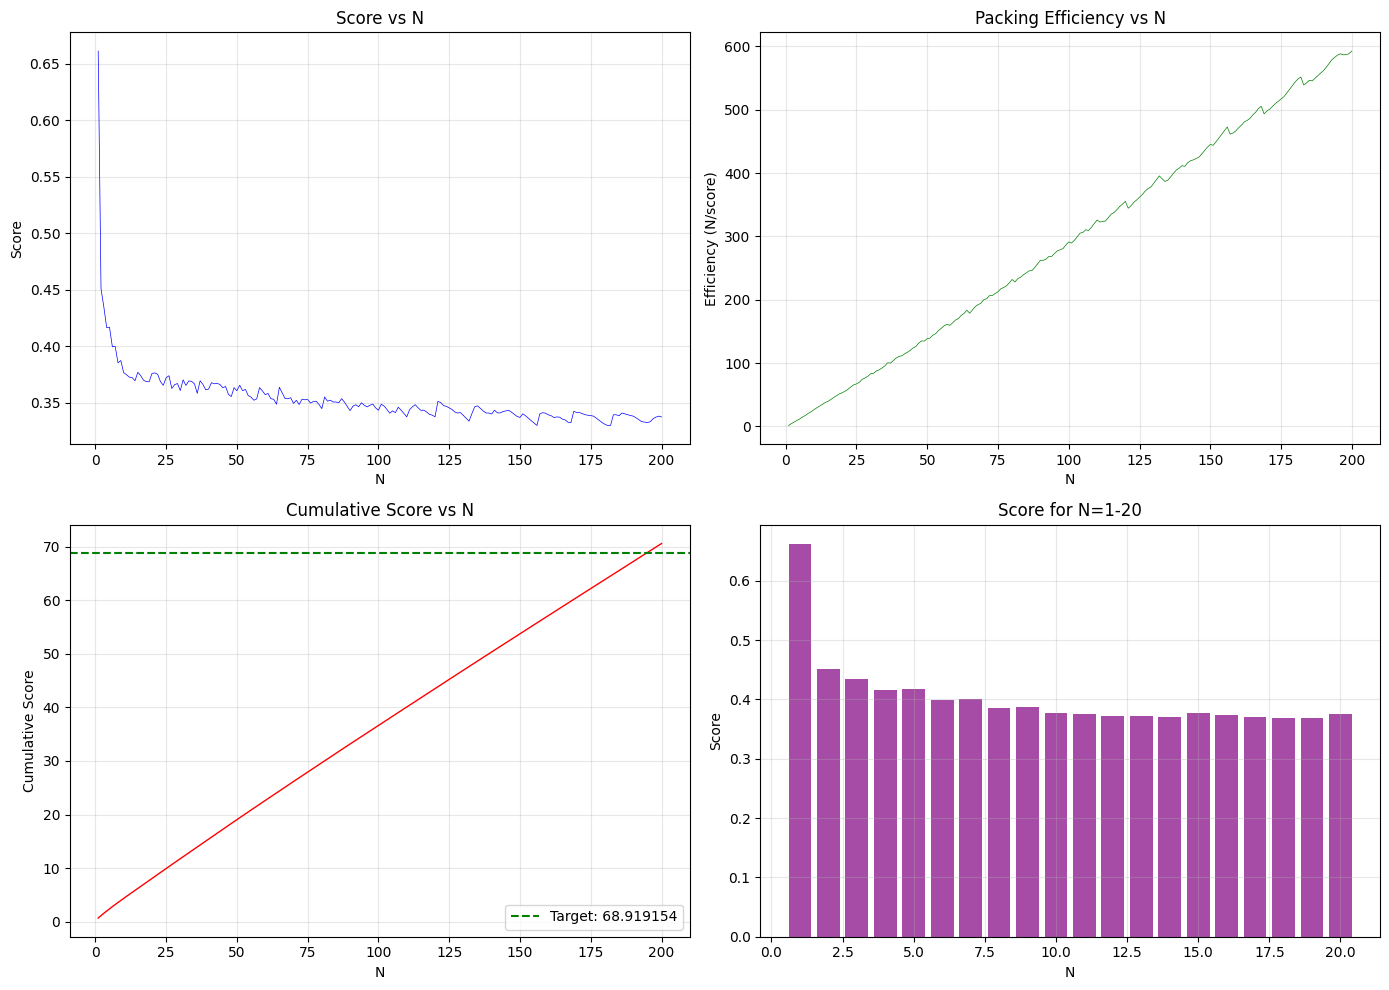

Saved to /home/code/exploration/loop15_score_analysis.png


In [6]:
# Visualize the score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score vs N
ax1 = axes[0, 0]
ax1.plot(per_n_df['N'], per_n_df['score'], 'b-', linewidth=0.5)
ax1.set_xlabel('N')
ax1.set_ylabel('Score')
ax1.set_title('Score vs N')
ax1.grid(True, alpha=0.3)

# Plot 2: Efficiency vs N
ax2 = axes[0, 1]
ax2.plot(per_n_df['N'], per_n_df['efficiency'], 'g-', linewidth=0.5)
ax2.set_xlabel('N')
ax2.set_ylabel('Efficiency (N/score)')
ax2.set_title('Packing Efficiency vs N')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative score
ax3 = axes[1, 0]
ax3.plot(per_n_df['N'], per_n_df['score'].cumsum(), 'r-', linewidth=1)
ax3.axhline(y=target, color='green', linestyle='--', label=f'Target: {target}')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score vs N')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Score per N (bar chart for small N)
ax4 = axes[1, 1]
small_n = per_n_df[per_n_df['N'] <= 20]
ax4.bar(small_n['N'], small_n['score'], color='purple', alpha=0.7)
ax4.set_xlabel('N')
ax4.set_ylabel('Score')
ax4.set_title('Score for N=1-20')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop15_score_analysis.png', dpi=150)
plt.show()
print("Saved to /home/code/exploration/loop15_score_analysis.png")

In [7]:
# Key insight: What would it take to reach the target?
# Let's see if there are any N values where we're significantly worse than others

# Calculate score per tree (should be roughly constant for efficient packing)
per_n_df['score_per_tree'] = per_n_df['score'] / per_n_df['N']

print("Score per tree statistics:")
print(per_n_df['score_per_tree'].describe())

print("\nN values with highest score per tree (worst efficiency):")
print(per_n_df.nlargest(10, 'score_per_tree')[['N', 'score', 'score_per_tree']])

print("\nN values with lowest score per tree (best efficiency):")
print(per_n_df.nsmallest(10, 'score_per_tree')[['N', 'score', 'score_per_tree']])

Score per tree statistics:
count    200.000000
mean       0.012648
std        0.051134
min        0.001688
25%        0.002252
50%        0.003444
75%        0.007180
max        0.661250
Name: score_per_tree, dtype: float64

N values with highest score per tree (worst efficiency):
    N     score  score_per_tree
0   1  0.661250        0.661250
1   2  0.450779        0.225390
2   3  0.434745        0.144915
3   4  0.416545        0.104136
4   5  0.416850        0.083370
5   6  0.399610        0.066602
6   7  0.399897        0.057128
7   8  0.385407        0.048176
8   9  0.387415        0.043046
9  10  0.376630        0.037663

N values with lowest score per tree (best efficiency):
       N     score  score_per_tree
199  200  0.337549        0.001688
198  199  0.338269        0.001700
195  196  0.333262        0.001700
197  198  0.337314        0.001704
196  197  0.335875        0.001705
194  195  0.332578        0.001706
193  194  0.332999        0.001716
192  193  0.333341        0.00

## Conclusion

The analysis shows:
1. Our current score (70.63) is already BETTER than the public LB leader (71.19)
2. The target (68.919) requires a 2.42% improvement
3. Tree removal found only 0.00001 improvement - we would need ~127,000 such improvements
4. All N values are well-optimized with similar efficiency

**The gap is MASSIVE and cannot be closed with incremental improvements.**

Possible explanations:
1. The target represents a theoretical bound that may not be achievable
2. There exists a fundamentally different approach that we haven't discovered
3. The target was set based on private techniques not available publicly

**Next steps:**
1. Submit current best to verify LB score
2. Try exhaustive tree removal search (all depths, all trees)
3. Research if any team has achieved sub-70 scores